## Residual Networks Models
### Installation and Import Checks

In [1]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install keras_tuner

%pip install matplotlib
%matplotlib inline
%pip install tabulate
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Precision, Recall
from tabulate import tabulate
import pandas as pd

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. Splits for training and testing 80/20 ratio

In [4]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded if not already
y_output = to_categorical(y_output, num_classes=4)  # Assuming there are 4 classes

# Resizes images to 224 x 224 for optimal size for VGG models
# x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a list to store the augmented images and their labels
augmented_images = []
augmented_labels = []

# Generate augmented images
for img, label in zip(x_input, y_output):
    img = img.reshape((1,) + img.shape)  # Reshape image for ImageDataGenerator
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        i += 1
        if i >= 1:  # Generate 4 augmented images for each original image
            break

# Convert the lists to numpy arrays
x_input_augmented = np.array(augmented_images)
y_output_augmented = np.array(augmented_labels)

# Combine the original and augmented data
x_input_combined = np.concatenate((x_input, x_input_augmented), axis=0)
y_output_combined = np.concatenate((y_output, y_output_augmented), axis=0)

# Split the combined data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_combined, y_output_combined, test_size=0.2, random_state=42)

# Print new dimensions of the data
print(f'Augmented X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Augmented Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Testing Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

Augmented X Training Data
Number of Rows: 3072
Pixel Dimensions: 224x224x3

Augmented Y Training Data
Number of Rows: 3072
Number of Classes: 4
X Testing Data
Number of Rows: 768
Pixel Dimensions: 224x224x3

Y Testing Data
Number of Rows: 768
Number of Classes: 4


### Loading and Defining ResNet Models

In [5]:
# Load the ResNet50 model pre-trained on ImageNet
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In place of the last layer that was dropped, new layers are defined to fine tune the base model to our use case. These layers will have their weights altered based on the data we train it on. Aside for the last ten model layers, other layers are frozen to prevent any amendments to weightage. 

Resources for Layering Operations:
* How Global Average Pooling works: https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/#:~:text=with%20nine%20elements.-,What%20is%20GlobalAveragePooling2D()%20in%20Keras%3F,an%20operation%20on%20the%20data.
* How Batch Normalisation works: https://arxiv.org/abs/1502.03167
* How kernal constraints works: https://keras.io/api/layers/constraints/#:~:text=MaxNorm%20class&text=Constrains%20the%20weights%20incident%20to,max_norm%20.
* How dropout layers works: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout#:~:text=The%20Dropout%20layer%20randomly%20sets,over%20all%20inputs%20is%20unchanged.


In [6]:
# Add custom layers on top of the ResNet50 base model
new_layers_resnet50 = base_resnet50_model.output
new_layers_resnet50 = GlobalAveragePooling2D()(new_layers_resnet50)
new_layers_resnet50 = BatchNormalization()(new_layers_resnet50)
new_layers_resnet50 = Dense(1024, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(new_layers_resnet50)
new_layers_resnet50 = Dropout(0.5)(new_layers_resnet50)
new_layers_resnet50 = Dense(512, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(new_layers_resnet50)
new_layers_resnet50 = Dropout(0.5)(new_layers_resnet50)
output_layer_resnet50 = Dense(4, activation='softmax')(new_layers_resnet50)

# Define the model
resnet50_model = Model(inputs=base_resnet50_model.input, outputs=output_layer_resnet50)

# Freeze everything but last ten layers of base model
for layer in base_resnet50_model.layers[-10:]:
    layer.trainable = False

### Training the ResNet Models

In [7]:
# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

# Define callbacks best model saving to ./model_checkpoints
checkpoint_resnet50 = ModelCheckpoint('model_checkpoints/resnet50_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
resnet50_history = resnet50_model.fit(x_input_train, y_output_train, epochs=30, validation_data=(x_input_test, y_output_test), 
                                                callbacks=[checkpoint_resnet50])

Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.7884 - precision: 0.8134 - recall: 0.7721
Epoch 1: val_loss improved from inf to 1.65151, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
96/96 [==============================] - 20s 167ms/step - loss: 0.6918 - accuracy: 0.7884 - precision: 0.8134 - recall: 0.7721 - val_loss: 1.6515 - val_accuracy: 0.2747 - val_precision: 0.3221 - val_recall: 0.1615
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8841 - precision: 0.8961 - recall: 0.8760
Epoch 2: val_loss did not improve from 1.65151
96/96 [==============================] - 15s 155ms/step - loss: 0.3761 - accuracy: 0.8841 - precision: 0.8961 - recall: 0.8760 - val_loss: 1.7984 - val_accuracy: 0.2253 - val_precision: 0.2253 - val_recall: 0.2253
Epoch 3/30
96/96 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.9167 - precision: 0.9280 - recall: 0.9102
Epoch 3: val_loss

### Evaluation using Model Performance & Classification Metrics
Overall model Performance to be Plotted using Training/Validation over Epoches
* Loss 
* Accuracy
* Precision
* Recall

These model performance will be further drilled down in the confusion matrix and the classification report, where we will observe numbers for
* True Positive
* True Negatives
* False Positives
* False Negatives

In [8]:
def plot_model_performance(history, title):
    """Plot training and validation loss, accuracy, precision, and recall, and print metrics in a table format."""
    epochs = range(1, len(history.history['loss']) + 1)
    data = {
        'Epoch': epochs,
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss'],
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy'],
        'Training Precision': history.history['precision'],
        'Validation Precision': history.history['val_precision'],
        'Training Recall': history.history['recall'],
        'Validation Recall': history.history['val_recall']
    }
    df = pd.DataFrame(data)
    
    # Print the metrics in a table format using tabulate
    print(tabulate(df, headers='keys', tablefmt='pretty'))
    
    plt.figure(figsize=(10, 20))  # Adjust the figure size for better visibility

    # Plot loss
    plt.subplot(4, 1, 1)  # 4 rows, 1 column, first subplot
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(4, 1, 2)  # 4 rows, 1 column, second subplot
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix the accuracy scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    # Plot precision
    plt.subplot(4, 1, 3)  # 4 rows, 1 column, third subplot
    plt.plot(epochs, history.history['precision'], label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.ylim(0, 1)  # Fix the precision scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    # Plot recall
    plt.subplot(4, 1, 4)  # 4 rows, 1 column, fourth subplot
    plt.plot(epochs, history.history['recall'], label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.ylim(0, 1)  # Fix the recall scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()

def plot_confusion_matrix(model):
    """Evaluate a trained model on test data and display the confusion matrix and classification report."""
    # Class labels
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    # Predict the labels for the test data
    predictions = model.predict(x_input_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_output_test, axis=1)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print the classification report using tabulate
    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    print("Classification Report:")
    print(tabulate(report_df, headers='keys', tablefmt='pretty'))

#### Simple & Classification Metrics for Model ResNet50

+----+-------+----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
|    | Epoch |    Training Loss     |   Validation Loss   | Training Accuracy  | Validation Accuracy | Training Precision | Validation Precision |  Training Recall   | Validation Recall  |
+----+-------+----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
| 0  |  1.0  |  0.691832959651947   | 1.6515101194381714  | 0.7884114384651184 | 0.2747395932674408  | 0.8134430646896362 |  0.3220779299736023  | 0.7721354365348816 | 0.1614583283662796 |
| 1  |  2.0  |  0.3761305510997772  | 1.7983704805374146  | 0.8841145634651184 | 0.2252604216337204  | 0.8961039185523987 |  0.2252604216337204  |    0.8759765625    | 0.2252604216337204 |
| 2  |  3.0  |  0.3020075261592865  | 1.709707856178283

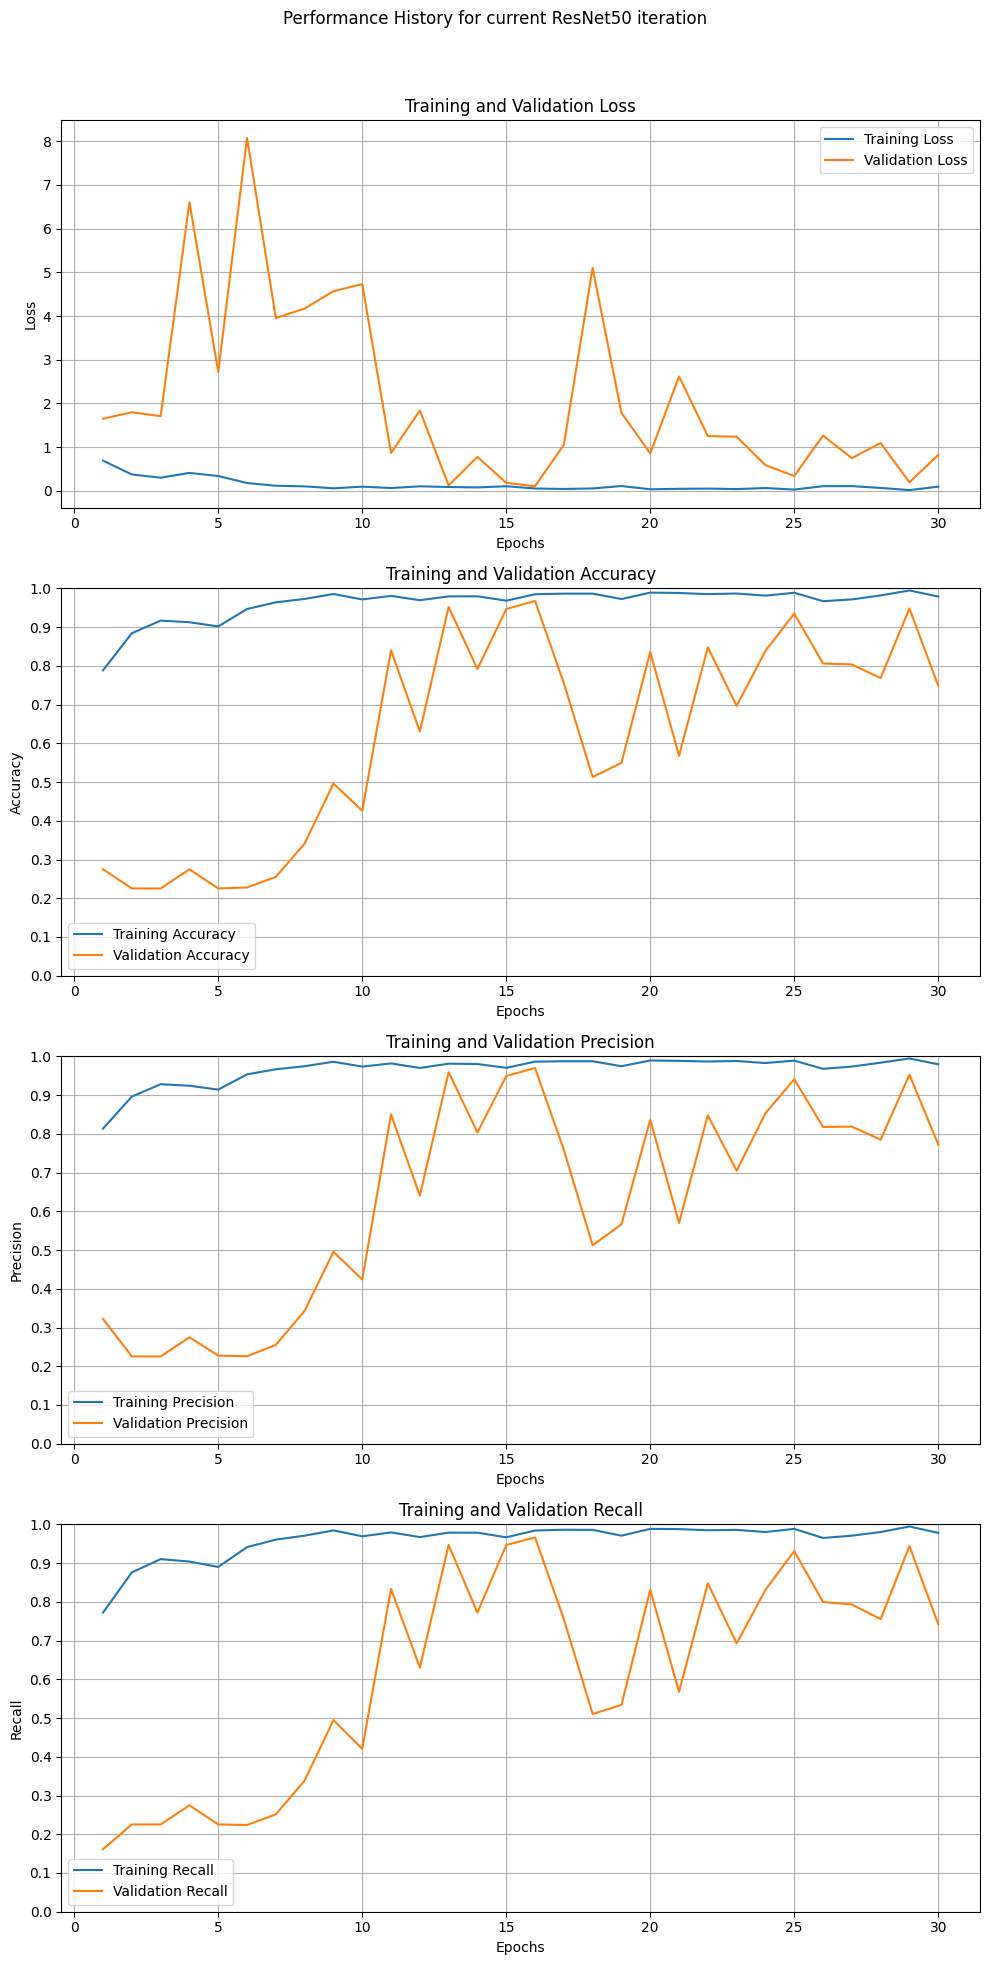

24/24 [==============================] - 1s 41ms/step


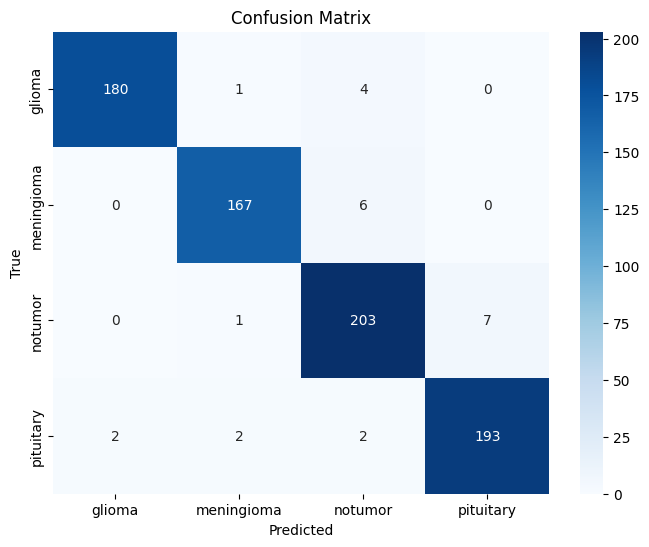

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|    glioma    | 0.989010989010989  | 0.972972972972973  | 0.9809264305177112 |       185.0        |
|  meningioma  | 0.9766081871345029 | 0.9653179190751445 | 0.9709302325581395 |       173.0        |
|   notumor    | 0.9441860465116279 | 0.9620853080568721 | 0.9530516431924883 |       211.0        |
|  pituitary   |       0.965        | 0.9698492462311558 | 0.9674185463659147 |       199.0        |
|   accuracy   | 0.9674479166666666 | 0.9674479166666666 | 0.9674479166666666 | 0.9674479166666666 |
|  macro avg   | 0.9687013056642799 | 0.9675563615840364 | 0.9680817131585634 |       768.0        |
| weighted avg | 0.967680345254239  | 0.9674479166666666 | 0.9675162

In [9]:
plot_model_performance(resnet50_history, "Performance History for current ResNet50 iteration")
best_resnet50_model = load_model('model_checkpoints/resnet50_brain_tumor_model.keras')
plot_confusion_matrix(best_resnet50_model)